# Project PubMed NLP

The purpose of this project is to build NLP models to make reading medical abstracts easier.

We're going to be replicating the deep learning model used in 2017 paper [*PubMed 200k RCT*](https://arxiv.org/abs/1710.06071)

Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*  


After reading the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## What we're going to cover

Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most wrong predictions

## Confirm access to a GPU

In [22]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ee21d306-213e-70e0-f0da-2c5474f7c883)


In [23]:
# Main tools used in project
import random
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset the used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [24]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [25]:
# Verify which files are present in the PubMed_20k dataset.
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [26]:
# Starting our experiments with a 20k dataset where numbers have been replaced with the "@" symbol.
data_dir ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [27]:
# Checking all od the filenames in the target directory
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data - we need to know what we dealling with.

And one of the best ways is to visualize them.

Lets make a function to read in all of the lines of a target text file.

In [28]:
# Create function to read the lines of a document
def retrieve_lines(filename):
  """
  Retrieves the lines of text from a given text file.

  Args:
      filename (str): The path of the target text file.

  Returns:
      list: A list of strings representing each line of text from the file.
  """
  with open(filename, 'r') as f:
    return f.readlines()

Let's try it out on the training data (`train.txt`).

In [29]:
# Let's see the training lines
train_lines = retrieve_lines(data_dir+'train.txt') # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [30]:
len(train_lines)

210040

When we extract lines from the training text file, we get a list of strings representing various abstract samples. Each string in the list corresponds to a sentence in the sample, along with the role the sentence plays in the summary.

To indicate the role of each sentence, we prefix it with a label at the beginning of each line, separated by a tab (\t). In addition, each sentence is terminated by a newline character (\n).

Different abstracts are identified by abstract IDs, which are lines starting with ###, and are separated by newlines (\n).

Based on this, it appears that we need to follow a few steps to prepare our samples for training our future machine learning model.

I want to create a function that performs the following steps:
* Takes a target file containing abstract samples as input.
* Reads the lines from the target file.
* For each line in the target file:
  * If the line starts with `###`, mark it as an abstract ID and the beginning of a new abstract.
    * Keep track of the number of lines in a sample.
  * If the line starts with `\n`, mark it as the end of an abstract sample.
    * Keep track of the total number of lines in a sample.
  * Capture the text before the `\t` as the label of the line.
  * Capture the text after the `\t` as the content of the line.
* Returns all the lines in the target text file as a list of dictionaries, where each dictionary contains the following key-value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g., `4`).
  * `"target"` - the role of the line in the abstract (e.g., `RESULTS`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total number of lines in an abstract sample (e.g., `16`).


  How I think, data will be represented:
```
[{'line_number':0,
    'target`: BACKGROUND,
    'text': 'These differences remained significant at @ weeks.\n',
    'total_lines': 11},
    ...]
```

In [31]:
def preprocess_lines(filename):
    """Preprocesses lines of text and assigns line numbers.

    Takes in a target text file, reads its contents, and sorts through each line,
    extracting information such as the target label, the text of the sentence,
    the number of sentences in the current abstract, and the sentence number
    of the target line.

    Args:
        filename (str): The path to the target text file to read and extract line data from.

    Returns:
        A list of dictionaries, each containing a line from the abstract, the line's label,
        the line's position in the abstract, and the total number of lines in the abstract
        that the line is from.
    """
    input_lines = retrieve_lines(filename) # Retrieve all lines from filename
    abs_lines = "" # Empty abstract
    abs_samples = [] # Empty list of abstracts

    # Go through each line in target file
    for line in input_lines:
      if line.startswith("###"): # Checking for ID line
        abs_id = line
        abs_lines = "" # Reset abstract string
      elif line.isspace(): # Check if line is a new line
        abs_line_split = abs_lines.splitlines() # Split into separate lines

        # Iterate through each line in abstract and count them at the same time
        for abs_line_num, abs_line in enumerate(abs_line_split):
          line_data = {} # Empty dict for line data
          target_text_split = abs_line.split("\t") # Split target label from text
          line_data["target"] = target_text_split[0] # Get target label
          line_data["text"] = target_text_split[1].lower() # Get target text and lower it
          line_data["line_number"] = abs_line_num # Number line
          line_data["total_lines"] = len(abs_line_split) - 1 # How many total lines are in the abstract
          abs_samples.append(line_data) # Add line data to abstract samples list

      else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
        abs_lines += line

    return abs_samples

Now let's use it to preprocess each of our RCT 20k datasets.

In [32]:
train_samples = preprocess_lines(data_dir + "train.txt")
val_samples = preprocess_lines(data_dir + "dev.txt") # dev set= validation set
test_samples = preprocess_lines(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [33]:
# Check the first abstract of our training data
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

I want to turn list of dictionaries into pandas DataFrame's for visualization

In [34]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [35]:
# Label distribution in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

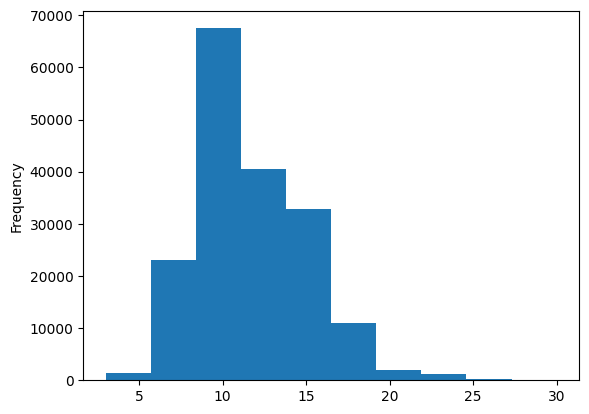

In [36]:
train_df.total_lines.plot.hist();

Most of the abstract are about 7 to 15 sentences.

### Get lists of sentences

During the construction of our deep learning model, one of the primary inputs will be a list of strings representing the lines of an abstract.

In [37]:
# Converting abstract text into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [38]:
# View the 10 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Make numeric labels

We're going to create one hot and label encoded labels.

In [39]:
from sklearn.preprocessing import OneHotEncoder
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False) # Instead of array return sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# Check encoded labels
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [40]:
from sklearn.preprocessing import LabelEncoder
# Extract labels ("target" columns) and encode them into integers

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [41]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Generating a series of model experiments.

We've proprocessed our data. It's time to start a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating model used in https://arxiv.org/pdf/1612.05251.pdf

## Model 0:

First model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fittting the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [43]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Okay, so 72.2% will be baseline accuracy to beat by other models I want to create.

Let's make somre predictions.

In [44]:
# Make predictions
model0_preds = model_0.predict(val_sentences)
model0_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate predictions, I want to make function to compare predictions across different metrics.

This function will help to obtain the following:
* Accuracy
* Precision
* Recall
* F1-score

In [64]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_score(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score.

  Args:
    y_true: true labels in the form of a 1D array
    y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)* 100
  # Calculate precision, recall and f1 using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [46]:
# Calculate baseline results
model0_results = calculate_score(y_true=val_labels_encoded,
                                   y_pred=model0_preds)
model0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence models

Before creating deeper models we need to create vectorization and embedding layers.

- `Vectorization layer` - convert text to numbers
- `Embedding layer` - find relations between those numbers

First things first - I think good idea is to find how many words are in each sentence.

For Tensorflow important is creating batches of the same size tensors.

In [47]:
# Length of each sentence on average
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len # Return average sentence length

26.338269273494777

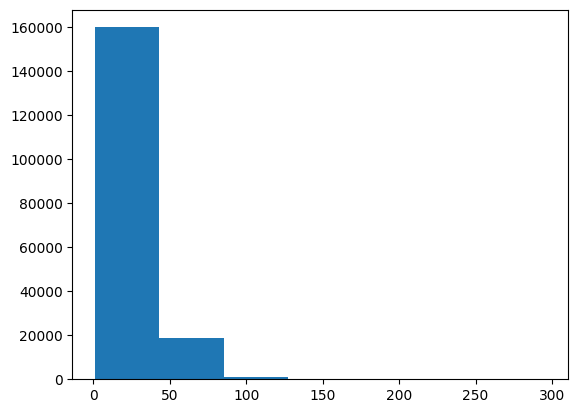

In [48]:
# Distribution
plt.hist(sent_len, bins=7);

Most of the sentences are between 0 and 50 tokens in length.

I want to find value to cover 95% of the sentences lengths.

In [49]:
# Lengths covering 95% sentences
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

In [50]:
# Checking max length in training set
max(sent_len)

296

I choose 95% and it shows training set have a mength of 55 tokens or less.

I don't want to use max sentence length because it would mean the majority of the data would be zeros.

### Text vectorizer

Creating a way to turn text into numbers - for this i want to use `TextVectorization`.

Parameters will be default except `max_token`(number of unique words in dataset) and `output_sequence_length`(desired output length)

In Section 3.2 of the [PubMed paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So that will be for us `max_tokens`.

In [51]:
# How many words in vocabulary
max_tokens = 68000

And `output_sequence_length` will be discovered sentence length of 55, which covers 95% of training sentences.

In [52]:
from tensorflow.keras.layers import TextVectorization
# Creating text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [53]:
# Adapting text vedtorizer on training sentences
text_vectorizer.adapt(train_sentences)

In [54]:
# Test on random sentences
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the duration of vein exposure was less in the eve group than in the ove group , amounting to @ @ min and @ @ min , respectively ( p < @ ) .

Length of text: 34

Vectorized text: [[    2   282     4  1701   455    10   211     5     2 10363    13    42
      5     2 19989    13 27491     6   242     3   242    83    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Now we've got a way to turn our sequences into numbers.

We can check some informatnions about text.


In [55]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"The number of words in the vocabulary: {len(rct_20k_text_vocab)}"),
print(f"The most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"The least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

The number of words in the vocabulary: 64841
The most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
The least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Creating a custom text embed

`token_vectorization` layer maps words in our text directly to numbers. This doesn't necessarily reflect the relationship between these numbers.

To create a richer numeric representation of our text, we can use **embedding**.

In [56]:
from tensorflow.keras import layers
# Create token embedding layer
token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                   output_dim=128,
                                   mask_zero=True, # use masking to handle variable sequence lenghts (save space)
                                name="token_embedding")

In [57]:
# Example of embedding
print(f"Before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"After vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embedding(vectorized_sentence)
print(f"After embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Before vectorization:
 the duration of vein exposure was less in the eve group than in the ove group , amounting to @ @ min and @ @ min , respectively ( p < @ ) .

After vectorization (before embedding):
 [[    2   282     4  1701   455    10   211     5     2 10363    13    42
      5     2 19989    13 27491     6   242     3   242    83    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

After embedding:
[[[ 0.04246488 -0.01899474 -0.01802098 ...  0.01259127  0.00217672
   -0.03185435]
  [ 0.03743437 -0.04059236  0.03680297 ... -0.03340121 -0.03399575
    0.04537355]
  [-0.00506549  0.03015694  0.04707923 ...  0.02995794  0.02593095
   -0.02437237]
  ...
  [ 0.00490538 -0.02594211  0.02978244 ...  0.04653926 -0.00683739
   -0.04859845]
  [ 0.00490538 -0.02594211  0.02978244 ...  0.04653926 -0.00683739
   -0.04859845]
  [ 0.00490538

## Creating datasets

I want to setup data to run as fast as possible with the Tensorflow tf.data API.

In [58]:
# Turn data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [59]:
# Take the Dataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Now we have a way to represent our text and labels numerically. Time to build a series of deep models to try to improve our model0.

In [60]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embedding(text_vectors)# Create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPool1D()(x) # Condense the output of out feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Get summaty of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   


Since the dataset is quite large(nearly 200,000 sentences), we will only use a portion of the training data to reduce the training time - it can be long even on GPU. Each model will have the same conditions, so at the end we will see a comparison.

In [62]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.3 * len(train_dataset)), # only fit on 30% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.3 * len(valid_dataset))) # only validate on 30% of batches

Epoch 1/3
1688/1688 [==============================] - 59s 29ms/step - loss: 0.6572 - accuracy: 0.7545 - val_loss: 0.5125 - val_accuracy: 0.8073
Epoch 2/3
1688/1688 [==============================] - 16s 10ms/step - loss: 0.5250 - accuracy: 0.8069 - val_loss: 0.4843 - val_accuracy: 0.8201
Epoch 3/3
1688/1688 [==============================] - 14s 8ms/step - loss: 0.4908 - accuracy: 0.8213 - val_loss: 0.4898 - val_accuracy: 0.8230


In [66]:
# Evaluate on whole validation dataset (we only validated on 30% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.4952 - accuracy: 0.8203


[0.4952097535133362, 0.8202701210975647]

In [67]:
# Predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[7.7803999e-01, 5.5604119e-02, 3.4589745e-02, 1.2412051e-01,
        7.6456354e-03],
       [5.5443943e-01, 3.4646717e-01, 5.8803661e-04, 9.1911986e-02,
        6.5934435e-03],
       [6.7245078e-01, 2.0683929e-02, 4.1159224e-03, 3.0141890e-01,
        1.3304263e-03],
       ...,
       [4.0293660e-05, 3.2646162e-04, 1.1099739e-02, 1.6339342e-05,
        9.8851717e-01],
       [2.9434633e-02, 6.7006063e-01, 2.6048526e-02, 1.1161096e-02,
        2.6329520e-01],
       [2.6430590e-02, 9.6869868e-01, 2.8389238e-03, 2.1388568e-04,
        1.8180205e-03]], dtype=float32)

In [68]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [69]:
# Calculate model_1 scores
model_1_results = calculate_score(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 82.02700913544288,
 'precision': 0.8298159274695472,
 'recall': 0.8202700913544287,
 'f1': 0.8136559044062273}

## Model 2: Expanding model by pre-trained token embeddings

This type of model is called transfer learning or **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and apply it to our problem.



To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer).
I'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [70]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [71]:
# Test out the pretrained embedding on a random srentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Lenght of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 in the control group , there were @ males and @ females , with a mean age of ( @ + / - @ ) years old ; the course of disease ranged from @ to @ year ; and the patients were treated by acupuncture massage instrument , @ minutes at a time , once a day for @ weeks .
Sentence after embedding:
[-0.05881279 -0.02620363  0.04863968  0.00633292 -0.07817743  0.00824774
  0.04713129 -0.02944288 -0.00132933 -0.03372408  0.08710005 -0.02593543
  0.02951732  0.01763493  0.05315353  0.01065105 -0.08841437  0.00382792
 -0.01404685 -0.05250733 -0.00923841 -0.00261456 -0.03044259  0.00378685
 -0.00229644  0.04358587 -0.05988709  0.00966337  0.02683227 -0.00582784]

Lenght of sentence embedding: 512


Okay, now let's put together and compile a model using `tf_hub_embedding_layer`.

### Building and fitting an NLP feature extraction model with TensorFlow Hub

In [72]:
# Define feature model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)# adding connected layer
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x) # Creating output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [73]:
# Fit the model
model_2.fit(train_dataset,
            steps_per_epoch=int(0.3 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.3 * len(valid_dataset)))

Epoch 1/3
1688/1688 [==============================] - 29s 15ms/step - loss: 0.7795 - accuracy: 0.6979 - val_loss: 0.6869 - val_accuracy: 0.7370
Epoch 2/3
1688/1688 [==============================] - 26s 15ms/step - loss: 0.6793 - accuracy: 0.7394 - val_loss: 0.6405 - val_accuracy: 0.7554
Epoch 3/3
1688/1688 [==============================] - 26s 16ms/step - loss: 0.6447 - accuracy: 0.7538 - val_loss: 0.6390 - val_accuracy: 0.7542


In [74]:
# Evaluate on validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6377 - accuracy: 0.7572


[0.6376654505729675, 0.757215678691864]

In [75]:
# Predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[6.7144221e-01, 2.2502959e-01, 5.4437254e-04, 9.9744909e-02,
        3.2388878e-03],
       [3.3903521e-01, 6.2556481e-01, 1.2132657e-03, 3.3666890e-02,
        5.1978615e-04],
       [5.4769760e-01, 3.9794732e-02, 2.7410813e-02, 3.6928412e-01,
        1.5812812e-02],
       ...,
       [6.5855042e-04, 7.6267542e-04, 1.2736510e-02, 1.1693949e-04,
        9.8572528e-01],
       [3.1212533e-02, 1.2755196e-01, 1.2296746e-01, 5.9256605e-03,
        7.1234238e-01],
       [1.1579612e-01, 8.5965341e-01, 2.2646980e-02, 1.8913139e-04,
        1.7143826e-03]], dtype=float32)

In [76]:
# Convert predicted probabilities found with a feature extraction model to encode labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [77]:
# Converting results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_score(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.72156758903746,
 'precision': 0.7616669954306642,
 'recall': 0.7572156758903746,
 'f1': 0.7507999465362204}

## Model 3: Conv1D with character embeddings.
Paper which I'm replicating states they used a combination of token and character-level embeddings.


### Creating a character-level tokenizer

In [78]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [79]:
# Make function to split sentences into characters
def char_segmentation(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
char_segmentation(random_train_sentence)

'i n   t h e   c o n t r o l   g r o u p   ,   t h e r e   w e r e   @   m a l e s   a n d   @   f e m a l e s   ,   w i t h   a   m e a n   a g e   o f   (   @   +   /   -   @   )   y e a r s   o l d   ;   t h e   c o u r s e   o f   d i s e a s e   r a n g e d   f r o m   @   t o   @   y e a r   ;   a n d   t h e   p a t i e n t s   w e r e   t r e a t e d   b y   a c u p u n c t u r e   m a s s a g e   i n s t r u m e n t   ,   @   m i n u t e s   a t   a   t i m e   ,   o n c e   a   d a y   f o r   @   w e e k s   .'

In [139]:
# Split sequence level data into character level data splits
train_chars = [char_segmentation(sentence) for sentence in train_sentences]
val_chars = [char_segmentation(sentence) for sentence in val_sentences]
test_chars = [char_segmentation(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [81]:
# Average character length
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

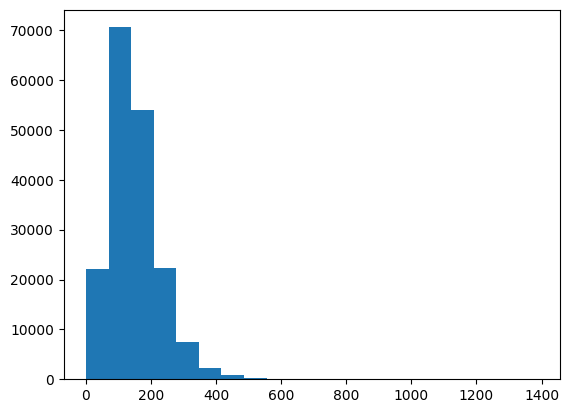

In [82]:
# Distribution of sequences at character-level
plt.hist(char_len, bins=20);

Most of sequences are between 0 and 200 characters long.

In [83]:
# Check what character length covers 95% od sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

I want to set `max_tokens` to 28 - 26 letters of alphabet, space and Unknown.

In [84]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [85]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + unknown
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Let's check some characteristics about our character-level sequences

In [86]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Num of different chars in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Num of different chars in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


Test on random sequence

In [87]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e r e   w a s   a l s o   n o   s t a t i s t i c a l   d i f f e r e n c e   b e t w e e n   t h e   t w o   g r o u p s   i n   t h e   p o s t p r o c e d u r e   p a i n   s c o r e s   (   p   =   @   )   .

Length of chars: 88

Vectorized chars:
[[ 3 13  2  8  2 20  5  9  5 12  9  7  6  7  9  3  5  3  4  9  3  4 11  5
  12 10  4 17 17  2  8  2  6 11  2 22  2  3 20  2  2  6  3 13  2  3 20  7
  18  8  7 16 14  9  4  6  3 13  2 14  7  9  3 14  8  7 11  2 10 16  8  2
  14  5  4  6  9 11  7  8  2  9 14  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

`output_seq_char_length` get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, since the `standarize` `TextVectorization` parameter is `"lower_and_strip_punctuation"` and the `split` parameter is `whitespace`  by default, symbols (such as `@`) and spaces are removed.

### Creating a character-level embedding

It's time to create a character-level embedding.


The input dimension `input_dim` will be equal to the number of different characters in `char_vocab` (28). Since we're following the structure of the model in Figure 1 of [*Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.

In [88]:
# Create char embedding layer
char_embedding = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character
                              mask_zero=False,
                              name="char_embedding")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e r e   w a s   a l s o   n o   s t a t i s t i c a l   d i f f e r e n c e   b e t w e e n   t h e   t w o   g r o u p s   i n   t h e   p o s t p r o c e d u r e   p a i n   s c o r e s   (   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-0.01775117  0.03583661  0.03394059 ... -0.02622436  0.03087708
    0.03835886]
  [ 0.01705595 -0.03677706  0.04351207 ... -0.00211719 -0.03679756
    0.04980706]
  [-0.04735384 -0.01052635 -0.02576905 ...  0.0419702  -0.02850562
    0.03480509]
  ...
  [ 0.01511123  0.04473691 -0.04358256 ...  0.03509356 -0.04394109
   -0.00871832]
  [ 0.01511123  0.04473691 -0.04358256 ...  0.03509356 -0.04394109
   -0.00871832]
  [ 0.01511123  0.04473691 -0.04358256 ...  0.03509356 -0.04394109
   -0.00871832]]]

Character embedding shape: (1, 290, 25)


As we see, each of the characters in sequences gets turned into a 25 dim embedding.

### Creating a Conv1D model to fit on character embeddings

Now I have a method for converting our character-level sequences into numbers (`char_vectorizer`), as well as representing them numerically as an embedding (`char_embedding`), let's evaluate their effectiveness in encoding the information in our sequences by building a character-level sequence model.

In [89]:
# Make Conv1D on chars
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Before fitting model one more thing I want to do first is creating character level batched `PrefetchedDataset's`

In [90]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Now, like other models, to save some time I'll fit the data on 30% of batches

In [91]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.3 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.3 * len(val_char_dataset)))

Epoch 1/3
1688/1688 [==============================] - 12s 6ms/step - loss: 1.0651 - accuracy: 0.5773 - val_loss: 0.8756 - val_accuracy: 0.6634
Epoch 2/3
1688/1688 [==============================] - 10s 6ms/step - loss: 0.8555 - accuracy: 0.6698 - val_loss: 0.7995 - val_accuracy: 0.6996
Epoch 3/3
1688/1688 [==============================] - 11s 6ms/step - loss: 0.8052 - accuracy: 0.6886 - val_loss: 0.7631 - val_accuracy: 0.7098


In [92]:
# Evaluate model_3 on validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7738 - accuracy: 0.7047


[0.7738348841667175, 0.7046868801116943]

In [93]:
# Predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.3872776 , 0.39159197, 0.06558409, 0.13899417, 0.01655223],
       [0.03290178, 0.90173566, 0.00569701, 0.00914738, 0.05051823],
       [0.22428145, 0.25885078, 0.19736819, 0.30265605, 0.01684355],
       ...,
       [0.00745812, 0.01593893, 0.02053007, 0.00204385, 0.95402896],
       [0.03385659, 0.09702054, 0.3329706 , 0.00571623, 0.53043604],
       [0.06576315, 0.89265287, 0.02642015, 0.00648223, 0.00868151]],
      dtype=float32)

In [94]:
# Converting predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [95]:
# Calculate Model 3 scores
model_3_results = calculate_score(y_true=val_labels_encoded,
                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 70.46868793856746,
 'precision': 0.6975728310659932,
 'recall': 0.7046868793856745,
 'f1': 0.6931513207072878}

## Model 4: pretrained token embeddings with character embeddings - hubrid embedding layer

Getting closer to building a model similar to the one in Figure 1 [*Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it's time for us to address the hybrid token embedding layer.


To start replicating the model to Figure 1, I will go through following steps:
1. Creating token level model
2. Creating character level model
3. Combine (using `layers.Concatenate`)
4. Building a series of output layers on top of 3(similar to Figure 1 and section 4.2)
5. Making a model that takes token and character level sequences as input and generates sequence label probabilities as output.

In [96]:
# 1. Creating token level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup character inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bd = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # Bidirectional shown in Figure 1
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bd)

# 3. Combine token and character inputs
token_char_concat = layers.Concatenate(name="token_char_layer")([token_model.output,
                                                                 char_model.output])

# 4. Building output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_drop = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_drop)
final_drop = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_drop)

# 5. Making model to connect it all together
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_character_embeddings")

In [97]:
# We can check summary
model_4.summary()

Model: "model_4_token_character_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   

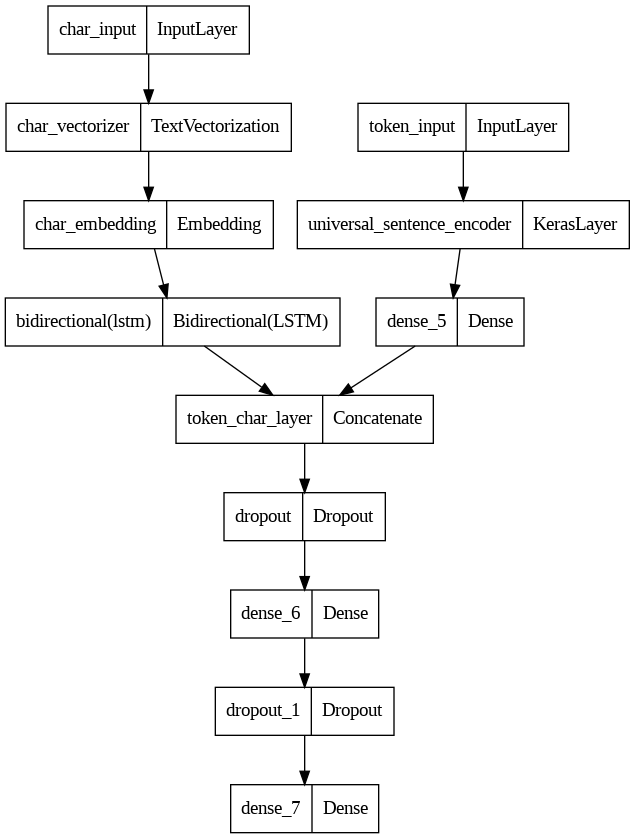

In [98]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [99]:
# Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Like before I'll use 30% od the data for training and validate.

But the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.`

### Combining token and character data into a `tf.data` dataset

In [100]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# Checking out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model 4

In [102]:
# Fit the model 4
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 38ms/step - loss: 0.9713 - accuracy: 0.6164 - val_loss: 0.7840 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7960 - accuracy: 0.6934 - val_loss: 0.7097 - val_accuracy: 0.7350
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7653 - accuracy: 0.7057 - val_loss: 0.6854 - val_accuracy: 0.7427


In [103]:
# Evaluate on validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6896 - accuracy: 0.7380


[0.6895525455474854, 0.7379518151283264]

In [104]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 20ms/step


array([[4.5741004e-01, 3.6557889e-01, 4.3410910e-03, 1.6101795e-01,
        1.1652008e-02],
       [3.7825841e-01, 4.3805510e-01, 3.9627831e-03, 1.7747270e-01,
        2.2509566e-03],
       [3.2324618e-01, 9.9056020e-02, 3.4531064e-02, 5.1820165e-01,
        2.4965094e-02],
       ...,
       [7.3228829e-04, 7.5786635e-03, 5.9755210e-02, 2.3422969e-04,
        9.3169963e-01],
       [1.0562699e-02, 7.0748523e-02, 1.9362897e-01, 5.3206808e-03,
        7.1973914e-01],
       [2.6137909e-01, 4.3434763e-01, 2.1961270e-01, 3.8418565e-02,
        4.6241984e-02]], dtype=float32)

In [105]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [106]:
# Get scores of hybrid model
model_4_results = calculate_score(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.79518072289156,
 'precision': 0.7372982397371478,
 'recall': 0.7379518072289156,
 'f1': 0.7354577173298347}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

I want to took mine own knowledge about the data and encoded it in a numerical way to give our model more information about our samples - **feature engineering**.

When we read in a text file of abstracts using `preprocess_text_with_line_numbers()` function, we counted the number of lines in an abstract as well as the number of each line itself.


In [107]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**.

### Creating positional embeddings

`"line_number"` and `"total_line"` columns are already numeric, you can pass them to model like this.

I want to use `tf.one_hot` on them to avoid the model thinking that a line with `"line number"=5` is five times bigger than a line with `"line number"=1`.

I need to know the arrangement of the `"line_number"` columns to find out what sets the `depth` in `tf.one_hot`

In [108]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

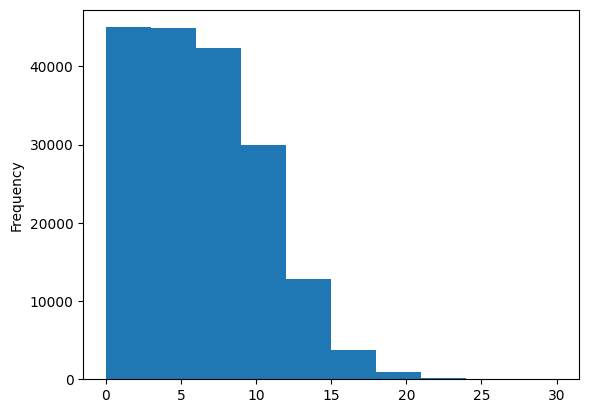

In [109]:
# Check the distribution of line_number
train_df.line_number.plot.hist()

Looking at the distribution of the `"line_number"` column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15.

In [133]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [111]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

I can do the same as for column `"line_number"` with column `"total_lines"`. First, I want to find the appropriate value for the "depth" parameter of the `tf.one_hot`.

In [112]:
# Numbers of different lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

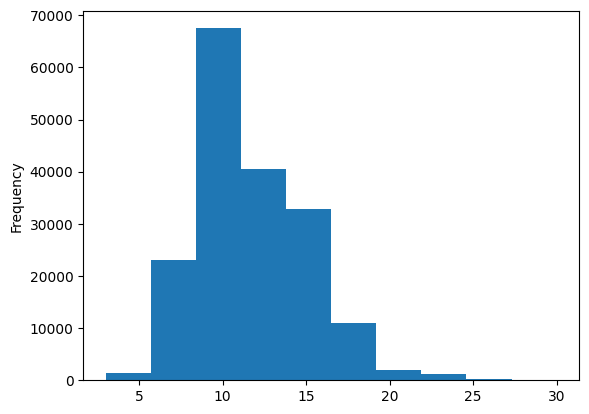

In [113]:
# Distribution of total lines
train_df.total_lines.plot.hist();

Looking at the distribution of our `"total_lines"` column, a value of 20 looks like it covers the majority of samples.

In [114]:
# Coverage of a "total_lines" value fo 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

It's time for one-hot-encode  `"total_lines"` column just as `"line_number"` column.

In [115]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a final model

I want to build a model that includes token embedding, character embedding, and our newly created positional embedding.

Steps:
1. Creating token level model
2. Creating character level model
3. Create a `"line_number"` model
4. Create a `"total_lines"` model
5. Combine (using `layers.Concatenate`) the outputs of 1 and 2 into a token-character hybrid embedding.
6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-character-positional embedding
7. Create an output layer to accept the embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`


In [116]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bd = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bd)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


There is a lot of code so I want to see summary

In [117]:
# Get a summary
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

Tensorflow gives tools for plotting so I will use them to visualize architecture of the model

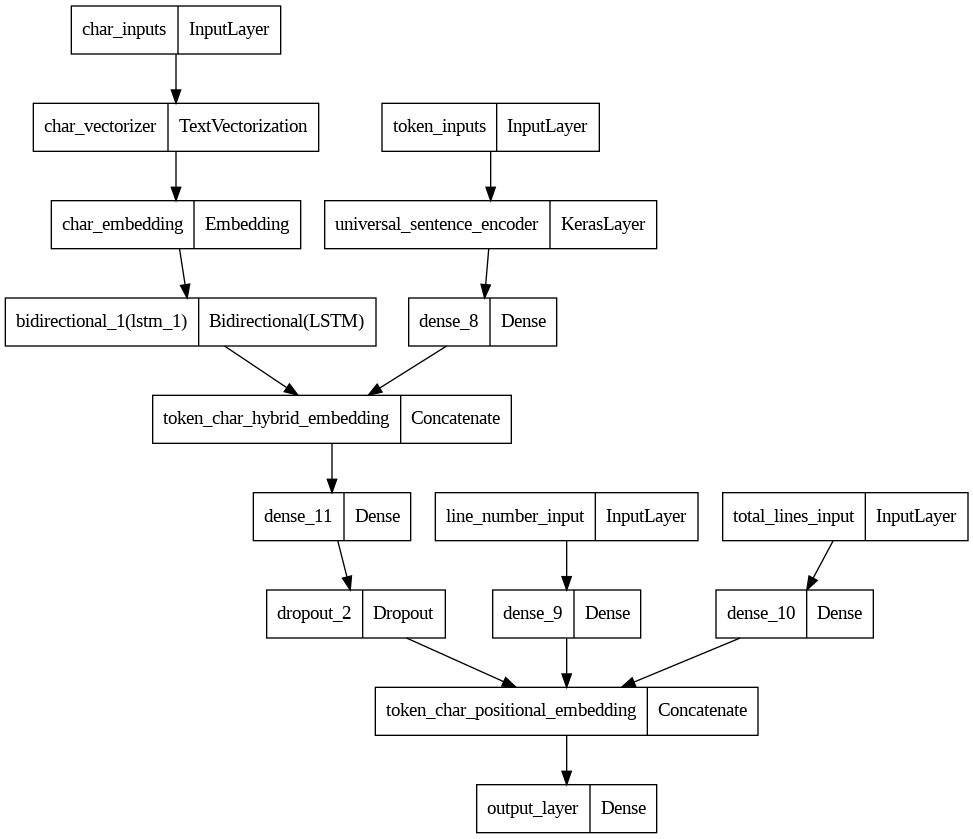

In [118]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

Model is constructed - let's compile it.

I will use parameter to loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

In [119]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7a524950bfd0> True
<keras.engine.input_layer.InputLayer object at 0x7a52496db820> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7a5204786a40> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7a52f86c9240> False
<keras.layers.core.embedding.Embedding object at 0x7a52f76c1390> True
<keras.layers.core.dense.Dense object at 0x7a52496db190> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7a5249535b40> True
<keras.layers.merging.concatenate.Concatenate object at 0x7a52495b9180> True
<keras.engine.input_layer.InputLayer object at 0x7a51ecc931c0> True
<keras.engine.input_layer.InputLayer object at 0x7a524950b490> True
<keras.layers.core.dense.Dense object at 0x7a52494216c0> True
<keras.layers.core.dense.Dense object at 0x7a524959c1c0> True
<keras.layers.core.dense.Dense object at 0x7a524958b820> True
<keras.layers.regularization.dropout.Dropout object at 0x7a524950b460> True
<keras.layers

In [120]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create embeddings datasets and fit our created model.

I need four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

In [121]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predistions with our last model

In [122]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 31s 42ms/step - loss: 1.0999 - accuracy: 0.7174 - val_loss: 0.9870 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 0.9684 - accuracy: 0.8134 - val_loss: 0.9525 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9526 - accuracy: 0.8227 - val_loss: 0.9416 - val_accuracy: 0.8321


In the paper they've used `optimizer=SGD` but i will stick with Adam for my project.

Time to make some predictions with it and evaluate them just as I've done before.

In [123]:
# Make predictions with model 5
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 21s 21ms/step


array([[0.5103586 , 0.11413733, 0.01069549, 0.3473425 , 0.01746614],
       [0.532071  , 0.10943666, 0.04804852, 0.29904246, 0.01140127],
       [0.28388515, 0.09529296, 0.09499017, 0.4575743 , 0.06825744],
       ...,
       [0.03442077, 0.11142232, 0.04571996, 0.0305436 , 0.7778934 ],
       [0.0298466 , 0.27305275, 0.06981068, 0.02660093, 0.60068905],
       [0.20695831, 0.60022545, 0.06939177, 0.04951065, 0.07391379]],
      dtype=float32)

In [124]:
# Turning prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [125]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_score(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.14576989275785,
 'precision': 0.8306357045490825,
 'recall': 0.8314576989275785,
 'f1': 0.8302264553461364}

## Compare model results

It's time to compare the performance of each model with each other.

Since all the results of our models are in dictionaries, it's a good idea to combine them in a DataFrame for visualization.

In [126]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": model0_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "finall_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,82.027009,0.829816,0.820270,0.813656
pretrained_token_embed,75.721568,0.761667,0.757216,0.750800
custom_char_embed_conv1d,70.468688,0.697573,0.704687,0.693151
hybrid_char_token_embed,73.795181,0.737298,0.737952,0.735458
finall_pos_char_token_embed,83.145770,0.830636,0.831458,0.830226


In [127]:
# Reducing the accuracy to same scale
all_model_results["accuracy"] = all_model_results["accuracy"]/100

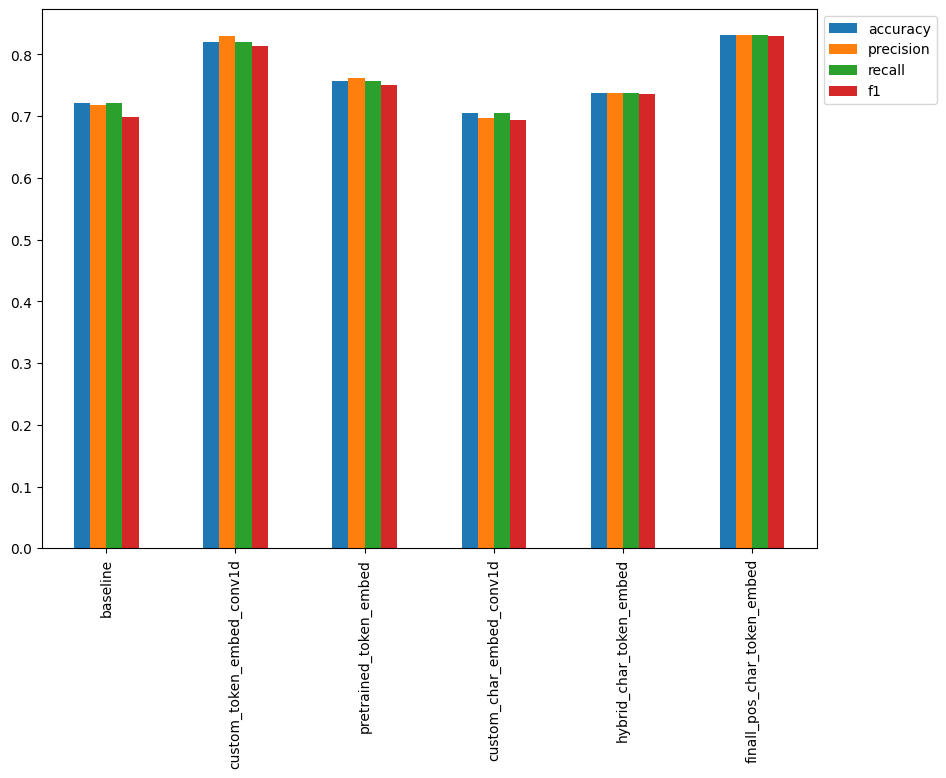

In [128]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

The [*PubMed 200k RCT*](https://arxiv.org/pdf/1710.06071.pdf) paper compares their tested model's F1-scores on the test dataset. So, I'll take at our model's F1-scores.

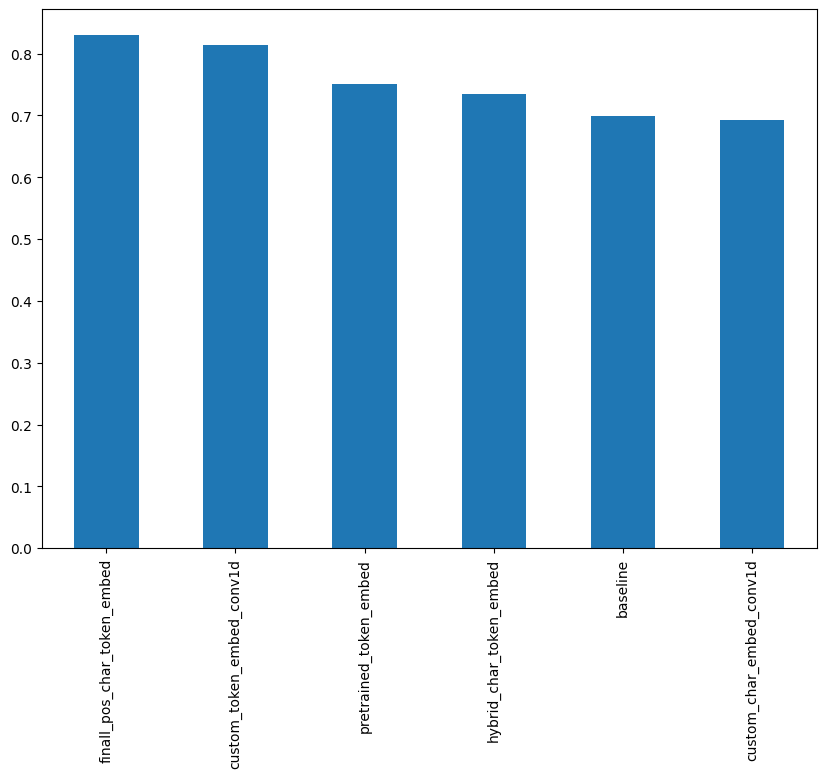

In [129]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Based on F1-scores, it looks like our finall embedding model performs the best by a fair margin.

Though, in comparison to the results reported in Table 3 of the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper, our model's F1-score is still underperforming (the authors model achieves an F1-score of 90.0 on the 20k RCT dataset versus our F1-score of ~82.6).

### Important point:
* Our models (with an exception for the baseline) have been trained on ~54,000 (30% of batches) samples of sequences and labels rather than the full ~180,000 in the 20k RCT dataset.

## Save and load best performing model

The point that working with models cannot do without is saving and loading models.

In [131]:
# Save best performing model to SavedModel format (default)
model_5.save("Pubmed_model")

## Finall evaluation on test dataset

To make our model's performance more comparable with the results reported in Table 3 of the `PubMed 200k RCT` paper, let's make predictions on the test dataset and evaluate them.

In [ ]:
test_chars =test_chars[:30]

In [140]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [141]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 25s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [142]:
# Evaluate model test predictions
model_5_test_results = calculate_score(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_5_test_results

{'accuracy': 82.63149162103865,
 'precision': 0.8249084388334785,
 'recall': 0.8263149162103866,
 'f1': 0.8250469658868348}

Our best model has some ways to go to match the performance of the results in the paper (their model gets 90.0 F1-score on the test dataset, where as ours gets ~82.5 F1-score).

## Final words

From this place we can work on best model, upgrade scores, train for longer, fetch more data but for now I'll stop here.
